In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import time
import torch
import math
import glob
import cv2
import random
import os
import numpy as np
from PIL import Image
import datetime
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import LambdaLR

# Model

In [3]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * (torch.tanh(F.softplus(x)))


class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, activation, bn=True, bias=False):
        super().__init__()
        pad = (kernel_size - 1) // 2

        self.conv = nn.ModuleList()
        if bias:
            self.conv.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad))
        else:
            self.conv.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False))
        if bn:
            self.conv.append(nn.BatchNorm2d(out_channels))
        if activation == "mish":
            self.conv.append(Mish())
        elif activation == "leaky":
            self.conv.append(nn.LeakyReLU(0.1, inplace=True))
        elif activation == "linear":
            pass
        else:
            print("Convolution block seems to go wrong")
            exit(1)

    def forward(self, x):
        for l in self.conv:
            x = l(x)
        return x

### Backbone

In [4]:
class ResBlock(nn.Module):
    """
    Sequential residual blocks each of which consists of \
    two convolution layers.
    Args:
        ch (int): number of input and output channels.
        nblocks (int): number of residual blocks.
        shortcut (bool): if True, residual tensor addition is enabled.
    """

    def __init__(self, ch, nblocks=1, shortcut=True):
        super().__init__()
        self.shortcut = shortcut
        self.module_list = nn.ModuleList()
        for i in range(nblocks):
            resblock_one = nn.ModuleList()
            resblock_one.append(Conv(ch, ch, 1, 1, "mish"))
            resblock_one.append(Conv(ch, ch, 3, 1, "mish"))
            self.module_list.append(resblock_one)

    def forward(self, x):
        for module in self.module_list:
            h = x
            for res in module:
                h = res(h)
            x = x + h if self.shortcut else h
        return x


class DownSample0(nn.Module):
    def __init__(self):
        super(DownSample0, self).__init__()
        self.conv1 = Conv(32, 64, 3, 2, "mish")
        self.conv2 = Conv(64, 64, 1, 1, "mish")

        self.conv4 = Conv(64, 64, 1, 1, "mish")  # 這邊從1延伸出來
        self.conv5 = Conv(64, 32, 1, 1, "mish")
        self.conv6 = Conv(32, 64, 3, 1, "mish")  # 這邊有shortcut從4連過來

        self.conv8 = Conv(64, 64, 1, 1, "mish")

        self.conv10 = Conv(128, 64, 1, 1, "mish")  # 這邊的input是conv2+conv8 所以有128

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)

        x3 = self.conv4(x1)
        x4 = self.conv5(x3)
        x5 = x3 + self.conv6(x4)
        x6 = self.conv8(x5)

        x6 = torch.cat([x6, x2], dim=1)
        x7 = self.conv10(x6)
        return x7


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, res_blocks):
        super(DownSample, self).__init__()
        self.conv1 = Conv(in_channels, in_channels * 2, 3, 2, "mish")
        self.conv2 = Conv(in_channels * 2, in_channels, 1, 1, "mish")

        self.conv4 = Conv(in_channels * 2, in_channels, 1, 1, "mish")  # 這邊從1延伸出來
        self.resblock = ResBlock(ch=in_channels, nblocks=res_blocks)
        self.conv11 = Conv(in_channels, in_channels, 1, 1, "mish")

        self.conv13 = Conv(in_channels * 2, out_channels, 1, 1, "mish")  # 這邊的input是conv2+conv11 所以有128

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv4(x1)

        r = self.resblock(x3)
        x4 = self.conv11(r)

        x4 = torch.cat([x4, x2], dim=1)
        x5 = self.conv13(x4)
        return x5


class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = Conv(3, 32, 3, 1, "mish")
        self.down1 = DownSample0()
        self.down2 = DownSample(64, 128, 2)
        self.down3 = DownSample(128, 256, 8)
        self.down4 = DownSample(256, 512, 8)
        self.down5 = DownSample(512, 1024, 4)

    def forward(self, i):
        i = self.conv0(i)
        d1 = self.down1(i)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        return d3, d4, d5

### Neck

In [5]:
class Upsample(nn.Module):
    def __init__(self):
        super(Upsample, self).__init__()

    def forward(self, x, target_size, inference):
        assert (x.data.dim() == 4)
        _, _, tw, th = target_size

        if inference:
            B, C, W, H = x.size()
            return x.view(B, C, W, 1, H, 1).expand(B, C, W, tw // W, H, th // H).contiguous().view(B, C, tw, th)
        else:
            return F.interpolate(x, size=(tw, th), mode='nearest')


class Neck(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv(1024, 512, 1, 1, 'leaky')
        self.conv2 = Conv(512, 1024, 3, 1, 'leaky')
        self.conv3 = Conv(1024, 512, 1, 1, 'leaky')
        # SPP
        self.maxpool1 = nn.MaxPool2d(kernel_size=5, stride=1, padding=5 // 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=9, stride=1, padding=9 // 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=13, stride=1, padding=13 // 2)

        # R -1 -3 -5 -6
        # SPP
        self.conv4 = Conv(2048, 512, 1, 1, 'leaky')
        self.conv5 = Conv(512, 1024, 3, 1, 'leaky')
        self.conv6 = Conv(1024, 512, 1, 1, 'leaky')
        self.conv7 = Conv(512, 256, 1, 1, 'leaky')
        # UP
        self.upsample1 = Upsample()
        # R 85
        self.conv8 = Conv(512, 256, 1, 1, 'leaky')
        # R -1 -3
        self.conv9 = Conv(512, 256, 1, 1, 'leaky')
        self.conv10 = Conv(256, 512, 3, 1, 'leaky')
        self.conv11 = Conv(512, 256, 1, 1, 'leaky')
        self.conv12 = Conv(256, 512, 3, 1, 'leaky')
        self.conv13 = Conv(512, 256, 1, 1, 'leaky')
        self.conv14 = Conv(256, 128, 1, 1, 'leaky')
        # UP
        self.upsample2 = Upsample()
        # R 54
        self.conv15 = Conv(256, 128, 1, 1, 'leaky')
        # R -1 -3
        self.conv16 = Conv(256, 128, 1, 1, 'leaky')
        self.conv17 = Conv(128, 256, 3, 1, 'leaky')
        self.conv18 = Conv(256, 128, 1, 1, 'leaky')
        self.conv19 = Conv(128, 256, 3, 1, 'leaky')
        self.conv20 = Conv(256, 128, 1, 1, 'leaky')

    def forward(self, input, downsample4, downsample3, inference):
        x1 = self.conv1(input)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        # SPP
        # A maximum pool is applied to a sliding kernel of size say, 1×1, 5×5, 9×9, 13×13.
        # The spatial dimension is preserved. The features maps from different kernel sizes are then
        # concatenated together as output.
        m1 = self.maxpool1(x3)
        m2 = self.maxpool2(x3)
        m3 = self.maxpool3(x3)
        spp = torch.cat([m3, m2, m1, x3], dim=1)
        # SPP end
        x4 = self.conv4(spp)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        x7 = self.conv7(x6)
        # UP
        up = self.upsample1(x7, downsample4.size(), inference)
        # R 85
        x8 = self.conv8(downsample4)
        # R -1 -3
        x8 = torch.cat([x8, up], dim=1)

        x9 = self.conv9(x8)
        x10 = self.conv10(x9)
        x11 = self.conv11(x10)
        x12 = self.conv12(x11)
        x13 = self.conv13(x12)
        x14 = self.conv14(x13)

        # UP
        up = self.upsample2(x14, downsample3.size(), inference)
        # R 54
        x15 = self.conv15(downsample3)
        # R -1 -3
        x15 = torch.cat([x15, up], dim=1)

        x16 = self.conv16(x15)
        x17 = self.conv17(x16)
        x18 = self.conv18(x17)
        x19 = self.conv19(x18)
        x20 = self.conv20(x19)
        return x20, x13, x6

### YoloLayer

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, FloatTensor, alpha=0.75, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = FloatTensor([0, alpha])
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1))
        pt = torch.exp(-BCE_loss)
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss.mean()


class YoloLayer(nn.Module):
    def __init__(self, num_classes, anchors, stride, scale_x_y, ignore_thresh):
        super(YoloLayer, self).__init__()
        self.num_classes = num_classes
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.stride = stride
        self.scale_x_y = scale_x_y
        self.ignore_thresh = ignore_thresh
        # mask_anchors :
        # [1.5, 2.0, 2.375, 4.5, 5.0, 3.5],  as stride = 8
        # [2.25, 4.6875, 4.75, 3.4375, 4.5, 9.125],  as stride = 16
        # [4.4375, 3.4375, 6.0, 7.59375, 14.34375, 12.53125],  as stride = 32
        self.masked_anchors = [(a_w / self.stride, a_h / self.stride) for a_w, a_h in self.anchors]

        self.reduction = 'mean'
        self.use_ciou_loss = True

        self.obj_scale = 1
        self.noobj_scale = 100
        self.lambda_coord = 5
        self.lambda_ciou_scale = 3.54
        self.lambda_conf_scale = 64.3
        self.lambda_cls_scale = 37.4

    def build_targets(self, pred_boxes, pred_cls, target):

        ByteTensor = torch.cuda.ByteTensor if pred_boxes.is_cuda else torch.ByteTensor
        FloatTensor = torch.cuda.FloatTensor if pred_boxes.is_cuda else torch.FloatTensor

        nB, nA, nG, _, nC = pred_cls.size()
        img_size = nG * self.stride

        # Output tensors
        obj_mask = ByteTensor(nB, nA, nG, nG).fill_(0)
        noobj_mask = ByteTensor(nB, nA, nG, nG).fill_(1)
        class_mask = FloatTensor(nB, nA, nG, nG).fill_(0)
        iou_scores = FloatTensor(nB, nA, nG, nG).fill_(0)
        tx = FloatTensor(nB, nA, nG, nG).fill_(0)
        ty = FloatTensor(nB, nA, nG, nG).fill_(0)
        tw = FloatTensor(nB, nA, nG, nG).fill_(0)
        th = FloatTensor(nB, nA, nG, nG).fill_(0)
        tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)

        # Convert to position relative to box
        pred_boxes = pred_boxes * nG
        target_boxes = target[:, 2:6] * nG
        gxy = target_boxes[:, :2]
        gwh = target_boxes[:, 2:]
        # Get anchors with best iou
        ious = torch.stack([anchor_wh_iou(anchor, gwh) for anchor in self.masked_anchors])
        best_ious, best_n = ious.max(0)
        # Separate target values
        b, target_labels = target[:, :2].long().t()
        gx, gy = gxy.t()
        gw, gh = gwh.t()
        gi, gj = gxy.long().t()
        # Set masks
        obj_mask[b, best_n, gj, gi] = 1
        noobj_mask[b, best_n, gj, gi] = 0
        tconf = obj_mask.float()

        # Set noobj mask to zero where iou exceeds ignore threshold
        for i, anchor_ious in enumerate(ious.t()):
            noobj_mask[b[i], anchor_ious > self.ignore_thresh, gj[i], gi[i]] = 0
        # Coordinates
        tx[b, best_n, gj, gi] = gx - gx.floor()
        ty[b, best_n, gj, gi] = gy - gy.floor()
        # Width and height
        tw[b, best_n, gj, gi] = torch.log(gw / self.masked_anchors[best_n][:, 0] + 1e-16)
        th[b, best_n, gj, gi] = torch.log(gh / self.masked_anchors[best_n][:, 1] + 1e-16)
        # One-hot encoding of label
        tcls[b, best_n, gj, gi, target_labels] = 1
        # Compute label correctness and iou at best anchor
        class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
        #ious, ciou_loss = bbox_xywh_ciou(pred_boxes[b, best_n, gj, gi], target_boxes)
        ciou_loss = bbox_xywh_ciou(pred_boxes[b, best_n, gj, gi], target_boxes)

        #iou_scores[b, best_n, gj, gi] = ious

        # The scaled weight of bbox is used to balance the impact of small objects and large objects on loss.
        #bbox_loss_scale = 2.0 - 1.0 * gw * gh / (img_size ** 2)
        #ciou_loss = bbox_loss_scale * (1.0 - ciou_loss)
        ciou_loss = (1.0 - ciou_loss)

        if self.reduction == 'mean':
            ciou_loss = ciou_loss.mean()
        else:
            ciou_loss = ciou_loss.sum()

        obj_mask = obj_mask.type(torch.bool)
        noobj_mask = noobj_mask.type(torch.bool)

        return iou_scores, ciou_loss, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf

    def forward(self, output, target=None):
        # anchors = [12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401]
        # anchor_masks = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
        # strides = [8, 16, 32]
        # anchor_step = len(anchors) // num_anchors

        # Tensors for cuda support
        FloatTensor = torch.cuda.FloatTensor if output.is_cuda else torch.FloatTensor

        # output.shape-> [batch_size, num_anchors * (num_classes + 5), grid_size, grid_size]
        batch_size, grid_size = output.size(0), output.size(2)

        # prediction.shape-> torch.Size([1, num_anchors, grid_size, grid_size, num_classes + 5])
        prediction = (
            output.view(batch_size, self.num_anchors, self.num_classes + 5, grid_size, grid_size)
                  .permute(0, 1, 3, 4, 2).contiguous()
        )

        pred_x = torch.sigmoid(prediction[..., 0]) * self.scale_x_y - (self.scale_x_y - 1) / 2
        pred_y = torch.sigmoid(prediction[..., 1]) * self.scale_x_y - (self.scale_x_y - 1) / 2
        pred_w = prediction[..., 2]
        pred_h = prediction[..., 3]
        pred_conf = torch.sigmoid(prediction[..., 4])
        pred_cls = torch.sigmoid(prediction[..., 5:])

        # grid.shape-> [1, 1, 52, 52, 1]
        # 預測出來的(pred_x, pred_y)是相對於每個cell左上角的點，因此這邊需要由左上角往右下角配合grid_size加上對應的offset，畫出的圖才會在正確的位置上
        grid_x = torch.arange(grid_size).repeat(grid_size, 1).view([1, 1, grid_size, grid_size]).type(FloatTensor)
        grid_y = torch.arange(grid_size).repeat(grid_size, 1).t().view([1, 1, grid_size, grid_size]).type(FloatTensor)

        # anchor.shape-> [1, 3, 1, 1, 1]
        # 這邊我認為是要從anchors的大小來還原實際上的寬和高
        self.masked_anchors = FloatTensor(self.masked_anchors)
        anchor_w = self.masked_anchors[:, 0].view([1, self.num_anchors, 1, 1])
        anchor_h = self.masked_anchors[:, 1].view([1, self.num_anchors, 1, 1])

        # add offset and then normalize to 0~1
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = (pred_x + grid_x) / grid_size
        pred_boxes[..., 1] = (pred_y + grid_y) / grid_size
        pred_boxes[..., 2] = (torch.exp(pred_w) * anchor_w) / grid_size
        pred_boxes[..., 3] = (torch.exp(pred_h) * anchor_h) / grid_size

        output = torch.cat(
            (
                pred_boxes.view(batch_size, -1, 4),
                pred_conf.view(batch_size, -1, 1),
                pred_cls.view(batch_size, -1, self.num_classes),
            ),
            -1,
        )

        if target is None:
            return output, 0
        else:
            iou_scores, ciou_loss, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf = self.build_targets(
                pred_boxes=pred_boxes, pred_cls=pred_cls, target=target
            )

            # Loss : Mask outputs to ignore non-existing objects (except with conf. loss)
            loss_x = F.mse_loss(pred_x[obj_mask], tx[obj_mask], reduction=self.reduction)
            loss_y = F.mse_loss(pred_y[obj_mask], ty[obj_mask], reduction=self.reduction)
            loss_w = F.mse_loss(pred_w[obj_mask], tw[obj_mask], reduction=self.reduction)
            loss_h = F.mse_loss(pred_h[obj_mask], th[obj_mask], reduction=self.reduction)

            #loss_conf_obj = F.binary_cross_entropy(pred_conf[obj_mask], tconf[obj_mask], reduction=self.reduction)
            #loss_conf_noobj = F.binary_cross_entropy(pred_conf[noobj_mask], tconf[noobj_mask], reduction=self.reduction)
            FOCAL = FocalLoss(FloatTensor)
            loss_conf = (
                    self.obj_scale * FOCAL(pred_conf[obj_mask], tconf[obj_mask])
                    + self.noobj_scale * FOCAL(pred_conf[noobj_mask], tconf[noobj_mask])
            )
            loss_cls = F.binary_cross_entropy(pred_cls[obj_mask], tcls[obj_mask], reduction=self.reduction)

            """ binary_cross_entropy_with_logits似乎是沒辦法收斂
            loss_conf_obj = F.binary_cross_entropy_with_logits(
                pred_conf[obj_mask], tconf[obj_mask], reduction=self.reduction)
            loss_conf_noobj = F.binary_cross_entropy_with_logits(
                pred_conf[noobj_mask], tconf[noobj_mask], reduction=self.reduction)
            loss_cls = F.binary_cross_entropy_with_logits(pred_cls[obj_mask], tcls[obj_mask])
            """

            if self.use_ciou_loss:
                #loss_conf = self.obj_scale * loss_conf_obj + self.noobj_scale * loss_conf_noobj
                total_loss = (
                    self.lambda_ciou_scale * ciou_loss +
                    loss_conf +
                    self.lambda_cls_scale * loss_cls
                )
                print("{}, {}, {}".format(self.lambda_ciou_scale * ciou_loss,
                                          loss_conf,
                                          self.lambda_cls_scale * loss_cls))
            else:
                loss_box = self.lambda_coord * (loss_x + loss_y + loss_w + loss_h)
                #loss_conf = self.obj_scale * loss_conf_obj + self.noobj_scale * loss_conf_noobj
                total_loss = loss_box + loss_conf + loss_cls
                print("{}, {}, {}".format(loss_box, loss_conf, loss_cls))

            return output, total_loss

### Head

In [7]:
class Head(nn.Module):
    def __init__(self, output_ch, n_classes):
        super().__init__()
        self.conv1 = Conv(128, 256, 3, 1, 'leaky')
        self.conv2 = Conv(256, output_ch, 1, 1, 'linear', bn=False, bias=True)

        self.yolo1 = YoloLayer(
            num_classes=n_classes,
            anchors=[[12, 16], [19, 36], [40, 28]],
            stride=8, scale_x_y=1.2, ignore_thresh=0.7)

        # R -4
        self.conv3 = Conv(128, 256, 3, 2, 'leaky')

        # R -1 -16
        self.conv4 = Conv(512, 256, 1, 1, 'leaky')
        self.conv5 = Conv(256, 512, 3, 1, 'leaky')
        self.conv6 = Conv(512, 256, 1, 1, 'leaky')
        self.conv7 = Conv(256, 512, 3, 1, 'leaky')
        self.conv8 = Conv(512, 256, 1, 1, 'leaky')
        self.conv9 = Conv(256, 512, 3, 1, 'leaky')
        self.conv10 = Conv(512, output_ch, 1, 1, 'linear', bn=False, bias=True)

        self.yolo2 = YoloLayer(
            num_classes=n_classes,
            anchors=[[36, 75], [76, 55], [72, 146]],
            stride=16, scale_x_y=1.1, ignore_thresh=0.7)

        # R -4
        self.conv11 = Conv(256, 512, 3, 2, 'leaky')

        # R -1 -37
        self.conv12 = Conv(1024, 512, 1, 1, 'leaky')
        self.conv13 = Conv(512, 1024, 3, 1, 'leaky')
        self.conv14 = Conv(1024, 512, 1, 1, 'leaky')
        self.conv15 = Conv(512, 1024, 3, 1, 'leaky')
        self.conv16 = Conv(1024, 512, 1, 1, 'leaky')
        self.conv17 = Conv(512, 1024, 3, 1, 'leaky')
        self.conv18 = Conv(1024, output_ch, 1, 1, 'linear', bn=False, bias=True)

        self.yolo3 = YoloLayer(
            num_classes=n_classes,
            anchors=[[142, 110], [192, 243], [459, 401]],
            stride=32, scale_x_y=1.05, ignore_thresh=0.7)

    def forward(self, input1, input2, input3, target):
        x1 = self.conv1(input1)
        x2 = self.conv2(x1)

        x3 = self.conv3(input1)
        # R -1 -16
        x3 = torch.cat([x3, input2], dim=1)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        x7 = self.conv7(x6)
        x8 = self.conv8(x7)
        x9 = self.conv9(x8)
        x10 = self.conv10(x9)

        # R -4
        x11 = self.conv11(x8)
        # R -1 -37
        x11 = torch.cat([x11, input3], dim=1)

        x12 = self.conv12(x11)
        x13 = self.conv13(x12)
        x14 = self.conv14(x13)
        x15 = self.conv15(x14)
        x16 = self.conv16(x15)
        x17 = self.conv17(x16)
        x18 = self.conv18(x17)

        y1, loss1 = self.yolo1(x2, target)
        y2, loss2 = self.yolo2(x10, target)
        y3, loss3 = self.yolo3(x18, target)

        return torch.cat([y1, y2, y3], 1), loss1 + loss2 + loss3

### Main

In [8]:
class Yolo(nn.Module):
    def __init__(self, n_classes=80):
        super().__init__()
        output_ch = (4 + 1 + n_classes) * 3
        self.backbone = Backbone()
        self.neck = Neck()
        self.head = Head(output_ch, n_classes)

    def forward(self, i, target=None):
        if len(target) > 0:
          inference = True
        else:
          inference = False
        d3, d4, d5 = self.backbone(i)
        x20, x13, x6 = self.neck(d5, d4, d3, inference)
        output, loss = self.head(x20, x13, x6, target)
        return output, loss

In [9]:
class ImageFolder(Dataset):
    def __init__(self, folder_path, img_size=416):
        self.files = sorted(glob.glob("%s/*.png" % folder_path))
        self.img_size = img_size

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        #  Hight in {320, 416, 512, 608, ... 320 + 96 * n}
        #  Width in {320, 416, 512, 608, ... 320 + 96 * m}
        img_path = self.files[index % len(self.files)]

        # Extract image as PyTorch tensor
        img = transforms.ToTensor()(Image.open(img_path))
        # Pad to square resolution
        # img, _ = pad_to_square(img, 0)
        # Resize
        img = resize(img, self.img_size)
        return img_path, img


def horisontal_flip(images, targets):
    images = torch.flip(images, [-1])
    targets[:, 2] = 1 - targets[:, 2]
    return images, targets


def pad_to_square(img, pad_value):
    c, h, w = img.shape
    dim_diff = np.abs(h - w)
    # (upper / left) padding and (lower / right) padding
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    # Determine padding
    pad = (0, 0, pad1, pad2) if h <= w else (pad1, pad2, 0, 0)
    # Add padding
    img = F.pad(img, pad, "constant", value=pad_value)

    return img, pad


def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image


class ListDataset(Dataset):
    def __init__(self, list_path, img_size=416, augment=False, multiscale=False, normalized_labels=True):
        self.img_files = sorted(glob.glob("%s/*.jpg" % list_path))

        self.label_files = [
            path.replace("images", "labels").replace(".png", ".txt").replace(".jpg", ".txt")
            for path in self.img_files
        ]
        self.img_size = img_size
        self.max_objects = 100
        self.augment = augment
        self.multiscale = multiscale
        self.normalized_labels = normalized_labels
        self.min_size = self.img_size - 3 * 32
        self.max_size = self.img_size + 3 * 32
        self.batch_count = 0

    def __getitem__(self, index):
        # ---------
        #  Image
        # ---------

        img_path = self.img_files[index % len(self.img_files)].rstrip()

        # Extract image as PyTorch tensor
        img = transforms.ToTensor()(Image.open(img_path).convert('RGB'))

        # Handle images with less than three channels
        if len(img.shape) != 3:
            img = img.unsqueeze(0)
            img = img.expand((3, img.shape[1:]))

        _, h, w = img.shape
        h_factor, w_factor = (h, w) if self.normalized_labels else (1, 1)

        # Pad to square resolution
        img, pad = pad_to_square(img, 0)

        # show image
        # transform = transforms.ToPILImage(mode="RGB")
        # image = transform(img)
        # image.show()

        _, padded_h, padded_w = img.shape

        # ---------
        #  Label
        # ---------

        label_path = self.label_files[index % len(self.img_files)].rstrip()

        targets = None
        if os.path.exists(label_path):
            boxes = torch.from_numpy(np.loadtxt(label_path).reshape(-1, 5))
            # Extract coordinates for unpadded + unscaled image
            x1 = w_factor * (boxes[:, 1] - boxes[:, 3] / 2)
            y1 = h_factor * (boxes[:, 2] - boxes[:, 4] / 2)
            x2 = w_factor * (boxes[:, 1] + boxes[:, 3] / 2)
            y2 = h_factor * (boxes[:, 2] + boxes[:, 4] / 2)
            # Adjust for added padding
            x1 += pad[0]
            y1 += pad[2]
            x2 += pad[1]
            y2 += pad[3]
            # Returns (x, y, w, h)
            boxes[:, 1] = ((x1 + x2) / 2) / padded_w
            boxes[:, 2] = ((y1 + y2) / 2) / padded_h
            boxes[:, 3] *= w_factor / padded_w
            boxes[:, 4] *= h_factor / padded_h

            targets = torch.zeros((len(boxes), 6))
            targets[:, 1:] = boxes

        # Apply augmentations
        if self.augment:
            if np.random.random() < 0.5:
                img, targets = horisontal_flip(img, targets)

        return img_path, img, targets

    def collate_fn(self, batch):
        paths, imgs, targets = list(zip(*batch))
        # Remove empty placeholder targets
        targets = [boxes for boxes in targets if boxes is not None]
        # Add sample index to targets
        for i, boxes in enumerate(targets):
            boxes[:, 0] = i
        targets = torch.cat(targets, 0)
        # Selects new image size every tenth batch
        if self.multiscale and self.batch_count % 10 == 0:
            self.img_size = random.choice(range(self.min_size, self.max_size + 1, 32))
        # Resize images to input shape
        imgs = torch.stack([resize(img, self.img_size) for img in imgs])
        self.batch_count += 1
        return paths, imgs, targets

    def __len__(self):
        return len(self.img_files)

In [10]:
def get_color(c, x, max_val):
    colors = np.array([[1, 0, 1], [0, 0, 1], [0, 1, 1], [0, 1, 0], [1, 1, 0], [1, 0, 0]], dtype=np.float32)

    ratio = float(x) / max_val * 5
    i = int(math.floor(ratio))
    j = int(math.ceil(ratio))
    ratio = ratio - i
    r = (1 - ratio) * colors[i][c] + ratio * colors[j][c]
    return int(r * 255)


def plot_boxes(img, boxes, class_names, color=None):
    import cv2
    img = np.array(cv2.imread(img_path))

    width = img.shape[1]
    height = img.shape[0]
    for i in range(len(boxes)):
        box = boxes[i]
        x1 = int(box[0] * width)
        y1 = int(box[1] * height)
        x2 = int(box[2] * width)
        y2 = int(box[3] * height)

        if color:
            rgb = color
        else:
            rgb = (255, 0, 0)

        cls_conf = box[4]
        cls_id = box[5]
        classes = len(class_names)
        offset = cls_id * 123457 % classes
        red = get_color(2, offset, classes)
        green = get_color(1, offset, classes)
        blue = get_color(0, offset, classes)
        if color is None:
            rgb = (red, green, blue)
        img = cv2.putText(img, class_names[cls_id], (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1.2, rgb, 1)
        img = cv2.rectangle(img, (x1, y1), (x2, y2), rgb, 1)

    output_path = "outputs/" + img_path.split('/')[-1]
    cv2.imwrite(output_path, img)


def load_class_names(namesfile):
    class_names = []
    with open(namesfile, 'r') as fp:
        lines = fp.readlines()
    for line in lines:
        line = line.rstrip()
        class_names.append(line)
    return class_names

# Utils

In [11]:
def bbox_xywh_ciou(pred_boxes, target_boxes):
    assert pred_boxes.size() == target_boxes.size(), "Unmatch size of pred_boxes and target_boxes"

    pred_boxes = torch.cat([pred_boxes[..., :2] - pred_boxes[..., 2:] / 2,
                            pred_boxes[..., :2] + pred_boxes[..., 2:] / 2], dim=-1)
    target_boxes = torch.cat([target_boxes[..., :2] - target_boxes[..., 2:] / 2,
                              target_boxes[..., :2] + target_boxes[..., 2:] / 2], dim=-1)

    w1 = pred_boxes[:, 2] - pred_boxes[:, 0]
    h1 = pred_boxes[:, 3] - pred_boxes[:, 1]
    w2 = target_boxes[:, 2] - target_boxes[:, 0]
    h2 = target_boxes[:, 3] - target_boxes[:, 1]

    area1 = w1 * h1
    area2 = w2 * h2

    center_x1 = (pred_boxes[:, 2] + pred_boxes[:, 0]) / 2
    center_y1 = (pred_boxes[:, 3] + pred_boxes[:, 1]) / 2
    center_x2 = (target_boxes[:, 2] + target_boxes[:, 0]) / 2
    center_y2 = (target_boxes[:, 3] + target_boxes[:, 1]) / 2

    inter_max_xy = torch.min(pred_boxes[:, 2:], target_boxes[:, 2:])
    inter_min_xy = torch.max(pred_boxes[:, :2], target_boxes[:, :2])
    out_max_xy = torch.max(pred_boxes[:, 2:], target_boxes[:, 2:])
    out_min_xy = torch.min(pred_boxes[:, :2], target_boxes[:, :2])

    inter = torch.clamp((inter_max_xy - inter_min_xy), min=0)
    inter_area = inter[:, 0] * inter[:, 1]
    inter_diag = (center_x2 - center_x1) ** 2 + (center_y2 - center_y1) ** 2
    outer = torch.clamp((out_max_xy - out_min_xy), min=0)
    outer_diag = (outer[:, 0] ** 2) + (outer[:, 1] ** 2)
    union = area1 + area2 - inter_area
    u = (inter_diag) / outer_diag
    iou = inter_area / union
    v = (4 / (math.pi ** 2)) * torch.pow((torch.atan(w2 / h2) - torch.atan(w1 / h1)), 2)
    with torch.no_grad():
        S = 1 - iou
        alpha = v / (S + v)
    cious = iou - (u + alpha * v)
    cious = torch.clamp(cious, min=-1.0, max=1.0)

    return cious


def anchor_wh_iou(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area


def xywh2xyxy(x):
    y = torch.empty(x.shape)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


def iou(box1, box2):
    t1_x1, t1_y1, t1_x2, t1_y2 = box1
    t2_x1, t2_y1, t2_x2, t2_y2 = box2

    # 不知道為什麼有些值真的會小於0
    if t1_x1 < 0 or t1_x2 < 0 or t1_y1 < 0 or t1_y2 < 0 or t2_x1 < 0 or t2_x2 < 0 or t2_y1 < 0 or t2_y2 < 0:
        return 1

    interX = min(t1_x2, t2_x2) - max(t1_x1, t2_x1)
    interY = min(t1_y2, t2_y2) - max(t1_y1, t2_y1)

    if interX <= 0 or interY <= 0:
        return 0.0

    inter_area = interX * interY
    union_area = (t1_x2 - t1_x1) * (t1_y2 - t1_y1) + (t2_x2 - t2_x1) * (t2_y2 - t2_y1) - inter_area + 1e-16

    return inter_area / union_area


def nms(boxes, confs, nms_thresh=0.5):
    confs = np.squeeze(confs)
    order = np.argsort(confs)

    # nms algorithm
    keep = []
    while len(order) > 0:
        first_box_index, order = order[-1], order[:-1]
        box = boxes[first_box_index]

        # box looks like-> [(0, array([0.18615767, 0.22766608, 0.748049  , 0.7332627 ], dtype=float32)),
        #                   (1, array([0.19176558, 0.23242362, 0.73947287, 0.7266734 ], dtype=float32)), ...
        keep.append(first_box_index)
        box_order_that_can_be_kept = []
        for b in order:
            if iou(box, boxes[b]) < nms_thresh:
                box_order_that_can_be_kept.append(b)

        order = box_order_that_can_be_kept

    return np.array(keep)


def get_color(c, x, max_val):
    colors = np.array([[1, 0, 1], [0, 0, 1], [0, 1, 1], [0, 1, 0], [1, 1, 0], [1, 0, 0]], dtype=np.float32)

    ratio = float(x) / max_val * 5
    i = int(math.floor(ratio))
    j = int(math.ceil(ratio))
    ratio = ratio - i
    r = (1 - ratio) * colors[i][c] + ratio * colors[j][c]
    return int(r * 255)


def plot_boxes(img_path, boxes, class_names, color=None):
    import cv2
    img = np.array(cv2.imread(img_path))

    width = img.shape[1]
    height = img.shape[0]
    for i in range(len(boxes)):
        box = boxes[i]
        x1 = int(box[0] * width)
        y1 = int(box[1] * height)
        x2 = int(box[2] * width)
        y2 = int(box[3] * height)

        if color:
            rgb = color
        else:
            rgb = (255, 0, 0)

        cls_id = np.squeeze(box[5])
        classes = len(class_names)
        offset = cls_id * 123457 % classes
        red = get_color(2, offset, classes)
        green = get_color(1, offset, classes)
        blue = get_color(0, offset, classes)
        if color is None:
            rgb = (red, green, blue)
        img = cv2.putText(img, class_names[cls_id], (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1.2, rgb, 1)
        img = cv2.rectangle(img, (x1, y1), (x2, y2), rgb, 1)

    output_path = "outputs/" + img_path.split('/')[-1]
    cv2.imwrite(output_path, img)


def load_class_names(namesfile):
    class_names = []
    with open(namesfile, 'r') as fp:
        lines = fp.readlines()
    for line in lines:
        line = line.rstrip()
        class_names.append(line)
    return class_names

In [12]:
def post_processing(prediction, conf_thresh, nms_thresh):
    # 416 / 8, 16, 32 -> 52, 26, 13
    # box_array.shape-> [batch,  ((52 x 52) + (26 x 26) + (13 x 13)) x 3, 4]
    # confs.shape-> [batch,  ((52 x 52) + (26 x 26) + (13 x 13)) x 3, num_classes]
    prediction[..., :4] = xywh2xyxy(prediction[..., :4])
    box_array = prediction[..., :4].detach().cpu().numpy()
    confs = prediction[..., 4:5].detach() * prediction[..., 5:].detach()
    batch_size = len(prediction)

    # [batch, num, num_classes] --> [batch, num]
    # torch.max returns a namedtuple (values, indices) where values is the maximum value of each row of the
    # input tensor in the given dimension dim. And indices is the index location of each maximum value found (argmax).
    max_conf, max_id = torch.max(confs, dim=2, keepdim=True)
    max_conf, max_id = max_conf.cpu().numpy(), max_id.cpu().numpy()

    bboxes_batch = []
    for i in range(batch_size):
        # Thresholding by Object Confidence
        # squeeze的原因是要讓shape-> (n, 1) 變成 shape-> (n)
        argwhere = np.squeeze(max_conf[i] > conf_thresh)
        box_candidate = box_array[i, argwhere, :]  # 信心值有大於門檻的bounding box
        confs_candidate = max_conf[i, argwhere]  # 這些bounding box的信心值
        classes_label = max_id[i, argwhere]  # 這些bounding box對應到的label
        classes = np.unique(classes_label)

        bboxes = []
        # nms for candidate classes
        for j in classes:

            cls_argwhere = np.squeeze(classes_label == j)
            bbox = box_candidate[cls_argwhere, :]
            confs = confs_candidate[cls_argwhere]
            label = classes_label[cls_argwhere]

            keep = nms(bbox, confs, nms_thresh)

            if keep.size > 0:
                bbox = bbox[keep, :]
                confs = confs[keep]
                label = label[keep]

                for k in range(bbox.shape[0]):
                    bboxes.append([bbox[k, 0], bbox[k, 1], bbox[k, 2], bbox[k, 3], confs[k], label[k]])

        bboxes_batch.append(bboxes)

    return bboxes_batch

# Detect

In [ ]:
data_dir = "./gdrive/My Drive/yolov4/"
n_classes = 80
weightfile = data_dir + "weights/myyolo2.pth"
imgfile = data_dir + "data/img"
classes = data_dir + "data/coco.names"
img_size = 416
batch_size = 1

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
FloatTensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

class_names = load_class_names(classes)
pretrained_dict = torch.load(weightfile)
model = Yolo(n_classes=n_classes)
model = model.to(device)
model.load_state_dict(pretrained_dict)

model.eval()

dataset = ImageFolder(imgfile, img_size=img_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

boxes = []
imgs = []

start = time.time()
for img_path, img in dataloader:
    temp = time.time()
    img = torch.autograd.Variable(img.type(FloatTensor))
    temp1 = time.time()

    with torch.no_grad():
        output, _ = model(img)
        temp2 = time.time()
        box = post_processing(output, 0.4, 0.5)
        temp3 = time.time()
        boxes.extend(box)
        print('-----------------------------------')
        num = 0
        for b in box:
            num += len(b)
        print("{}-> {} objects found".format(img_path, num))
        print("Pre-processing time : ", round(temp1 - temp, 5))
        print("Inference time : ", round(temp2 - temp1, 5))
        print("Post-processing time : ", round(temp3 - temp, 5))
        print('-----------------------------------')
    imgs.extend(img_path)

for i, (img_path, box) in enumerate(zip(imgs, boxes)):
    plot_boxes(img_path, box, class_names)

end = time.time()

print('-----------------------------------')
print("Total detecting time : ", round(end - start, 5))
print('-----------------------------------')

-----------------------------------
('./gdrive/My Drive/yolov4/data/img/dog-cycle-car.png',)-> 3 objects found
Pre-processing time :  0.00066
Inference time :  0.04876
Post-processing time :  0.05105
-----------------------------------
-----------------------------------
Total detecting time :  0.08473
-----------------------------------


# Train

In [13]:
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive
!cp /mydrive/yolov4/data/vehicle_plate.zip ../
!unzip ../vehicle_plate.zip -d data/

'Colab Notebooks'   Datasets   Images   Kaggle	'My Drive'   NVCC   yolov4
Archive:  ../vehicle_plate.zip
   creating: data/vehicle_plate/
  inflating: data/vehicle_plate/2956bcbedfc167b6.txt  
  inflating: data/vehicle_plate/ad10c7d29f111692.txt  
  inflating: data/vehicle_plate/5641e6ad7d2600f2.txt  
  inflating: data/vehicle_plate/2e8a83cfb1afe7ba.txt  
  inflating: data/vehicle_plate/a9b2a2018f845393.txt  
  inflating: data/vehicle_plate/0f0596b1c511e071.jpg  
  inflating: data/vehicle_plate/a929dc75c20da7d8.txt  
  inflating: data/vehicle_plate/5daafbcf76fa6602.jpg  
  inflating: data/vehicle_plate/71881a9c0f7f0a86.txt  
  inflating: data/vehicle_plate/defd8f4b30b3e1e1.jpg  
  inflating: data/vehicle_plate/d6c5271e96ec1a61.jpg  
  inflating: data/vehicle_plate/8256e277c7f47797.jpg  
  inflating: data/vehicle_plate/7f56adf4b9306ac9.txt  
  inflating: data/vehicle_plate/a774a6f81fea258b.jpg  
  inflating: data/vehicle_plate/69450fa183d57a7b.txt  
  inflating: data/vehicle_plate/15a51

In [14]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [15]:
def create_lr_scheduler(optimizer, epochs):
    """Create learning rate scheduler for training process"""
    # Scheduler https://arxiv.org/pdf/1812.01187.pdf
    lf = lambda x: (((1 + math.cos(x * math.pi / epochs)) / 2) ** 1.0) * 0.9 + 0.1  # cosine
    lr_scheduler = LambdaLR(optimizer, lr_lambda=lf)
    # plot_lr_scheduler(optimizer, lr_scheduler, configs.num_epochs, save_dir=configs.logs_dir)

    return lr_scheduler

def weights_init_normal(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, torch.nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [19]:
data_dir = "./gdrive/My Drive/yolov4/"
n_classes = 1
weightfile = data_dir + "weights/myyolo2.pth"
imgfile = "data/vehicle_plate"
classes = data_dir + "data/coco.names"
img_size = 416
batch_size = 4
epochs = 50

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_plot = []
loss_total = 0.0

class_names = load_class_names(classes)
pretrained_dict = torch.load(weightfile)
model = Yolo(n_classes)
model = model.to(device)
model_dict = model.state_dict()

In [24]:
# 1. filter out unnecessary keys
# 第552項開始為yololayer，訓練時不需要用到
#pretrained_dict = {k: v for k, v in pretrained_dict.items() if np.shape(model_dict[k]) == np.shape(v)}
# 2. overwrite entries in the existing state dict
#model_dict.update(pretrained_dict)
# 3. load the new state dict
#model.apply(weights_init_normal)  # 權重初始化？
#model.load_state_dict(model_dict)

#train_dataset = ListDataset(imgfile)
#train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
#                                                pin_memory=False, collate_fn=train_dataset.collate_fn)
#num_iters_per_epoch = len(train_dataloader)

# optimizer = torch.optim.SGD(model.parameters(), lr=5e-2, momentum=0.9, weight_decay=1e-5)
#optimizer = torch.optim.Adam(model.parameters())
#lr_scheduler = create_lr_scheduler(optimizer, epochs)

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    loss_total = 0.0
    for batch, (_, imgs, targets) in enumerate(train_dataloader):
        # print(targets)
        global_step = num_iters_per_epoch * (epoch - 1) + batch + 1

        imgs = Variable(imgs.to(device), requires_grad=True)
        targets = Variable(targets.to(device), requires_grad=False)

        outputs, loss = model(imgs, targets)
        loss_total += loss.item()

        loss.backward()

        if global_step % 10 == 0:
            print("update")
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            print(loss)

    log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, epochs, batch, len(train_dataloader))
    print(log_str)

    loss_plot.append(loss_total)
torch.save(model.state_dict(), "yolov4_train.pth")

Streaming output truncated to the last 5000 lines.
0.7655926942825317, 0.016915492713451385, 0.0069893295876681805
0.999000072479248, 0.030639521777629852, 0.014038655906915665
1.1231884956359863, 0.011914177797734737, 0.004187858197838068
0.47534701228141785, 0.02687738835811615, 0.011889747343957424
0.6976536512374878, 0.022377679124474525, 0.010846739634871483
1.1042804718017578, 0.025623809546232224, 0.006851714104413986
0.761259913444519, 0.04379066452383995, 0.012321650981903076
1.3545316457748413, 0.053690675646066666, 0.005160211585462093
1.6900451183319092, 0.09155634045600891, 0.0014372816076502204
0.39329349994659424, 0.01896364614367485, 0.009555838070809841
0.5265960693359375, 0.02350713312625885, 0.006939322222024202
0.6024907827377319, 0.03147563710808754, 0.0029507388826459646
0.6032231450080872, 0.02807098999619484, 0.006235313136130571
0.9209365248680115, 0.041020482778549194, 0.009361227042973042
1.0622471570968628, 0.07306969165802002, 0.002294696168974042
0.3812555

In [25]:
#torch.save(model.state_dict(), "yolov4_train.pth")
!cp yolov4_train.pth /mydrive/yolov4/car_plate.pth

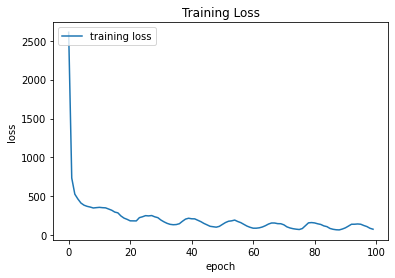

In [26]:
import matplotlib.pyplot as plt
plt.figure()

# plot your loss
plt.plot(loss_plot)

plt.title('Training Loss')
plt.ylabel('loss'), plt.xlabel('epoch')
plt.legend(['training loss'], loc = 'upper left')
plt.savefig('loss.png')
plt.show()

In [30]:
torch.cuda.empty_cache()
del model
del optimizer
del imgs
del targets